<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"


    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
from torch.utils.data import DataLoader

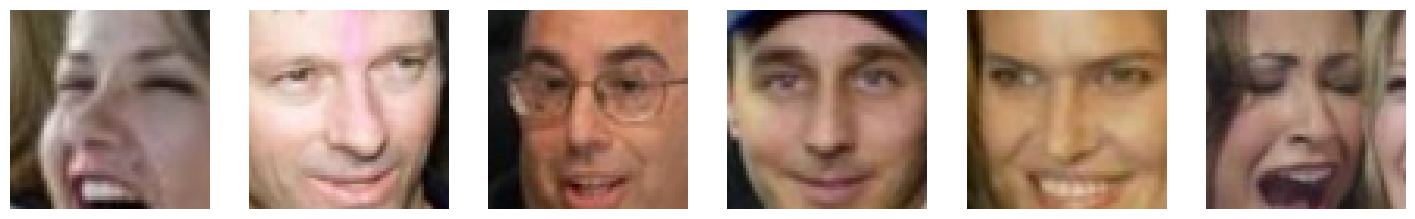

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
ix = np.random.choice(len(data), len(data), False)
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[ix[i]])
plt.show()

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

In [ ]:
X_train = torch.permute(torch.tensor(train_photos, dtype=torch.float32), (0, 3, 1, 2))
X_val = torch.permute(torch.tensor(val_photos, dtype=torch.float32), (0, 3, 1, 2))
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=128)

In [ ]:
for batch in train_loader:
  print(batch.shape)
  break

torch.Size([128, 3, 64, 64])


## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64 # выберите размер латентного вектора

In [ ]:
from re import X
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
          nn.ReLU(True),
          nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
          nn.ReLU(True),
          nn.Conv2d(32, dim_code, kernel_size=7),
      )
      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(dim_code, 32, kernel_size=7),
          nn.ReLU(True),
          nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(True),
          nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      )

    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)
      return reconstruction, latent_code


## 1.3 Обучение (2 балла)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = F.mse_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.04809707123786211
 Val loss: 0.01164321093396707


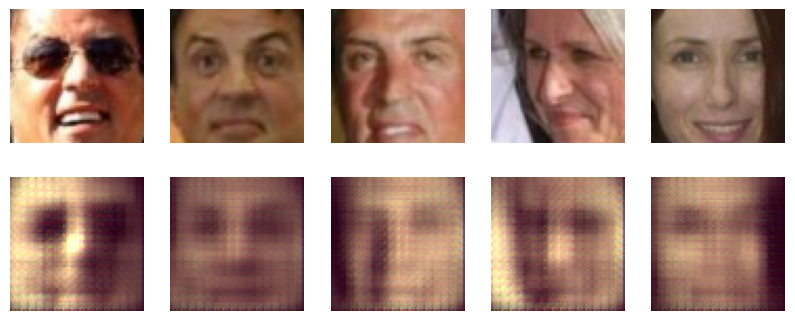

Epoch: 5
Train loss: 0.0029577799617082523
 Val loss: 0.002611881820484996


Epoch: 10
Train loss: 0.0018144024445885612
 Val loss: 0.0017087895063344729


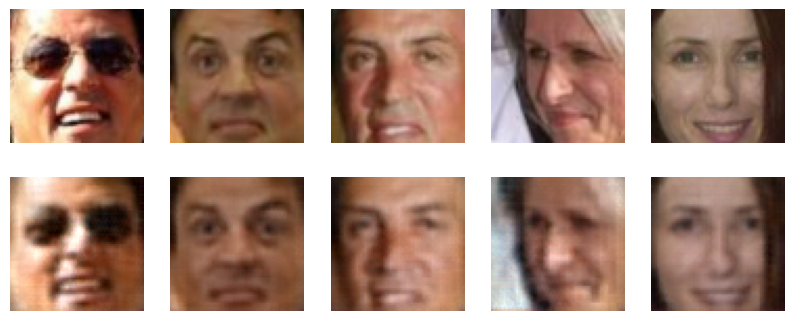

Epoch: 15
Train loss: 0.0013697122947202735
 Val loss: 0.0012983767823739486
Epoch: 20
Train loss: 0.001135826761764224
 Val loss: 0.0010861332782290199


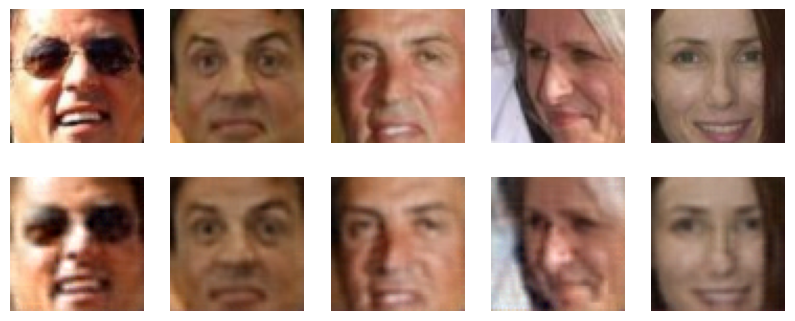

Epoch: 25
Train loss: 0.0010202277009876105
 Val loss: 0.0010938394433734093


Epoch: 30
Train loss: 0.0010394229251961475
 Val loss: 0.0009322683750228448


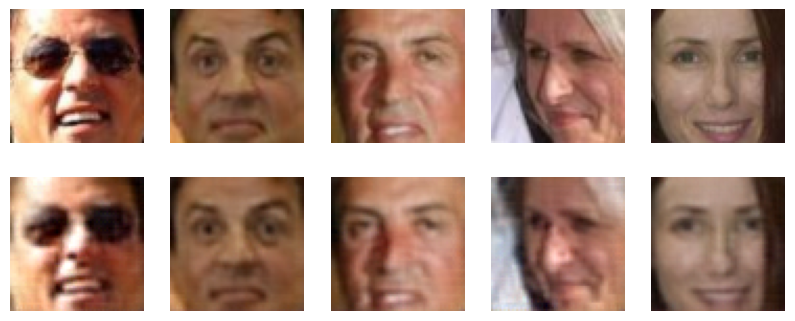

Epoch: 35
Train loss: 0.0008548986096616073
 Val loss: 0.0007694900162856687


Epoch: 40
Train loss: 0.0008423089760766234
 Val loss: 0.0006986923187717118


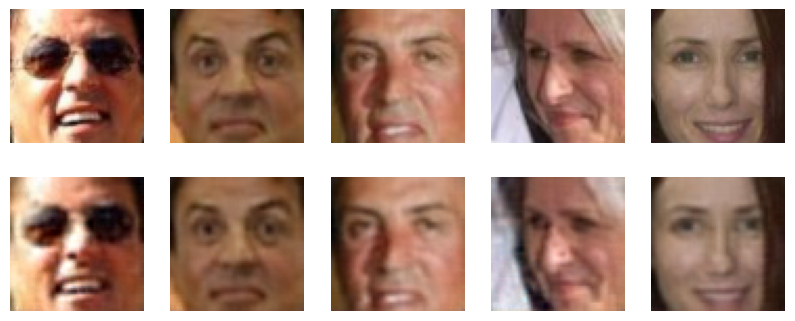

Epoch: 45
Train loss: 0.0006541782309130956
 Val loss: 0.0006331026247194545


Epoch: 50
Train loss: 0.0006079499532158176
 Val loss: 0.0005758997550318865


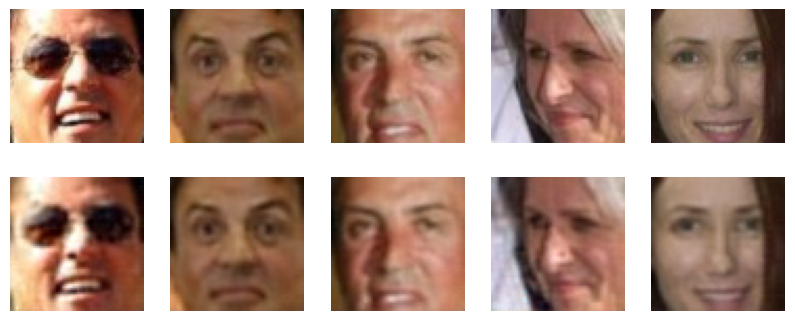

Epoch: 55
Train loss: 0.001552427635698389
 Val loss: 0.0013036683984947476


Epoch: 60
Train loss: 0.0007923263130128704
 Val loss: 0.0007555425241166217


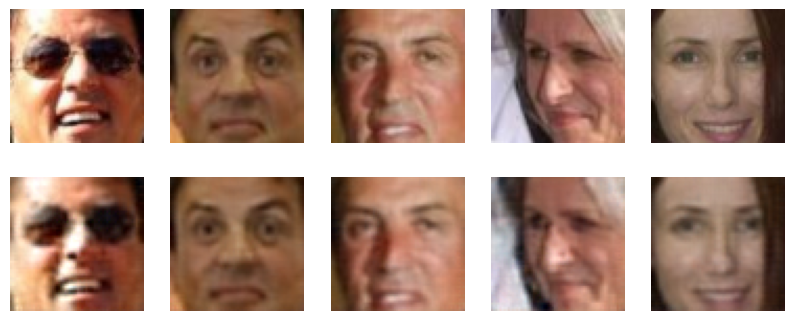

Epoch: 65
Train loss: 0.0006917198989740623
 Val loss: 0.0006457375976341692


Epoch: 70
Train loss: 0.0006015905127760464
 Val loss: 0.0005933632015843283


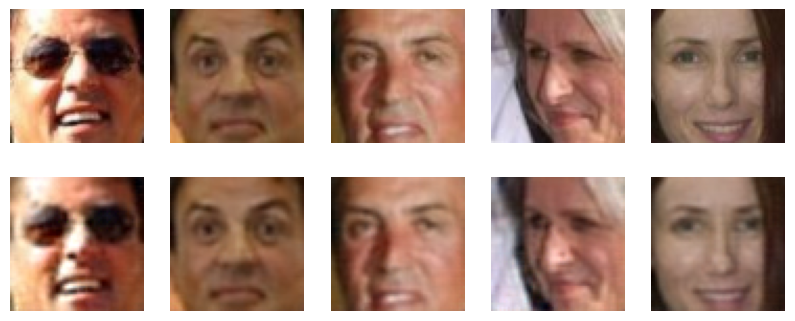

Epoch: 75
Train loss: 0.0008158354415378023
 Val loss: 0.0007650785370391201
Epoch: 80
Train loss: 0.0006286131352015961
 Val loss: 0.0006114060524851084


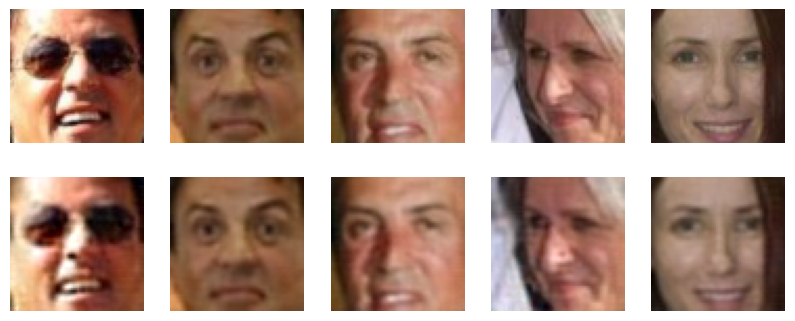

Epoch: 85
Train loss: 0.0005935151743332065
 Val loss: 0.0005531070214188235


Epoch: 90
Train loss: 0.0007053926419366592
 Val loss: 0.0005317193069706925


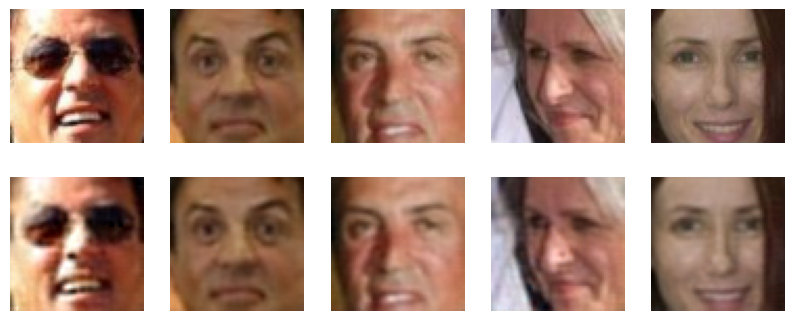

Epoch: 95
Train loss: 0.000597940850815165
 Val loss: 0.0004865167032800276


In [ ]:
n_epochs = 100
train_losses = []
val_losses = []
models = []

# Выбераем первые X изображений из валидационного набора данных
X = 5
val_images = next(iter(val_loader))[:X]
val_images = val_images.to(device)

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, _ = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed, _ = autoencoder(X_batch.to(device))
          loss = criterion(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    if epoch % 5 == 0:
        print("Epoch: " + str(epoch) + "\nTrain loss: " + str(train_losses[-1]))
        print(" Val loss: " + str(val_losses[-1]))
    if epoch % 10 == 0:
      models.append(autoencoder)

    # Визуализация реконструкций
    if epoch % 10 == 0:
      with torch.no_grad():
        autoencoder.eval()
        reconstructed, _ = autoencoder(val_images)
        val_images = val_images.cpu()
        reconstructed = reconstructed.cpu()
        fig, axs = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(X):
            axs[0, i].imshow(val_images[i].permute(1, 2, 0))
            axs[0, i].axis('off')
            axs[1, i].imshow(reconstructed[i].permute(1, 2, 0))
            axs[1, i].axis('off')
        plt.show()
        val_images = val_images.to(device)




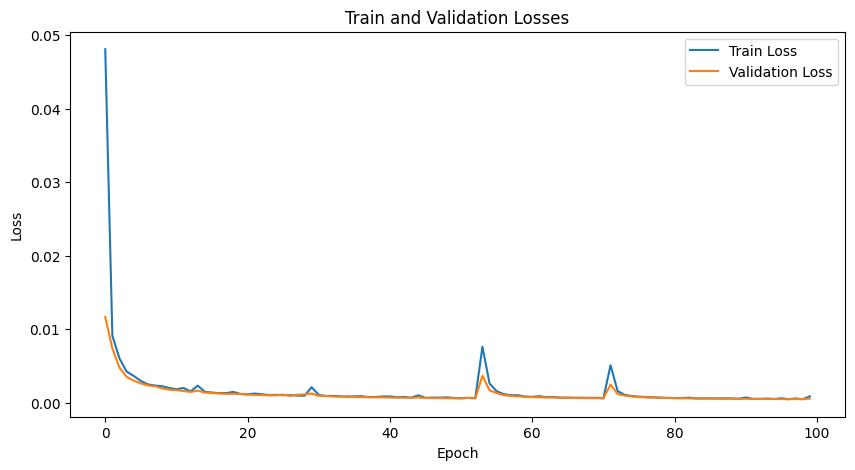

In [ ]:
# Визуализация графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

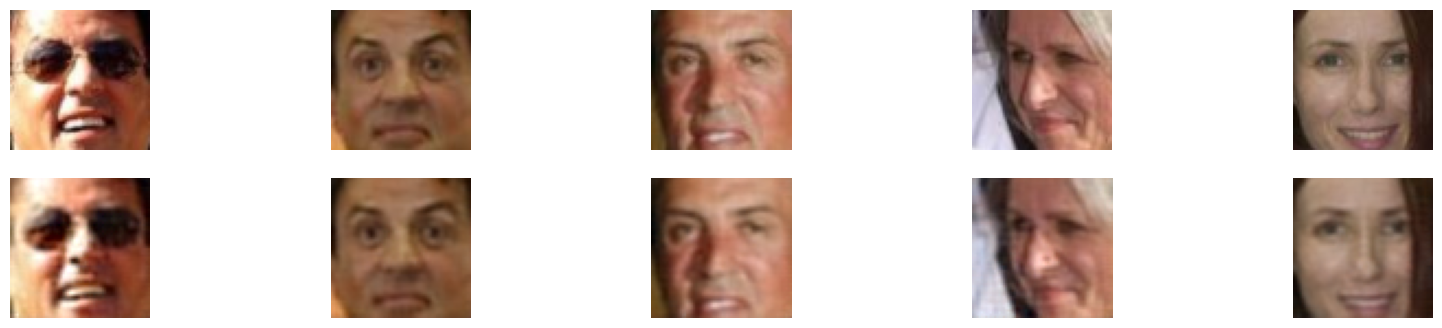

In [ ]:
# Получите реконструкции изображений
with torch.no_grad():
    autoencoder.eval()
    reconstructed, _ = autoencoder(val_images)

# Перемещаем данные на CPU для визуализации
val_images = val_images.cpu()
reconstructed = reconstructed.cpu()

# Выводим оригинальные и восстановленные изображения
fig, axs = plt.subplots(2, X, figsize=(20, 4))
for i in range(X):
    axs[0, i].imshow(val_images[i].permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed[i].permute(1, 2, 0))
    axs[1, i].axis('off')
plt.show()


Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

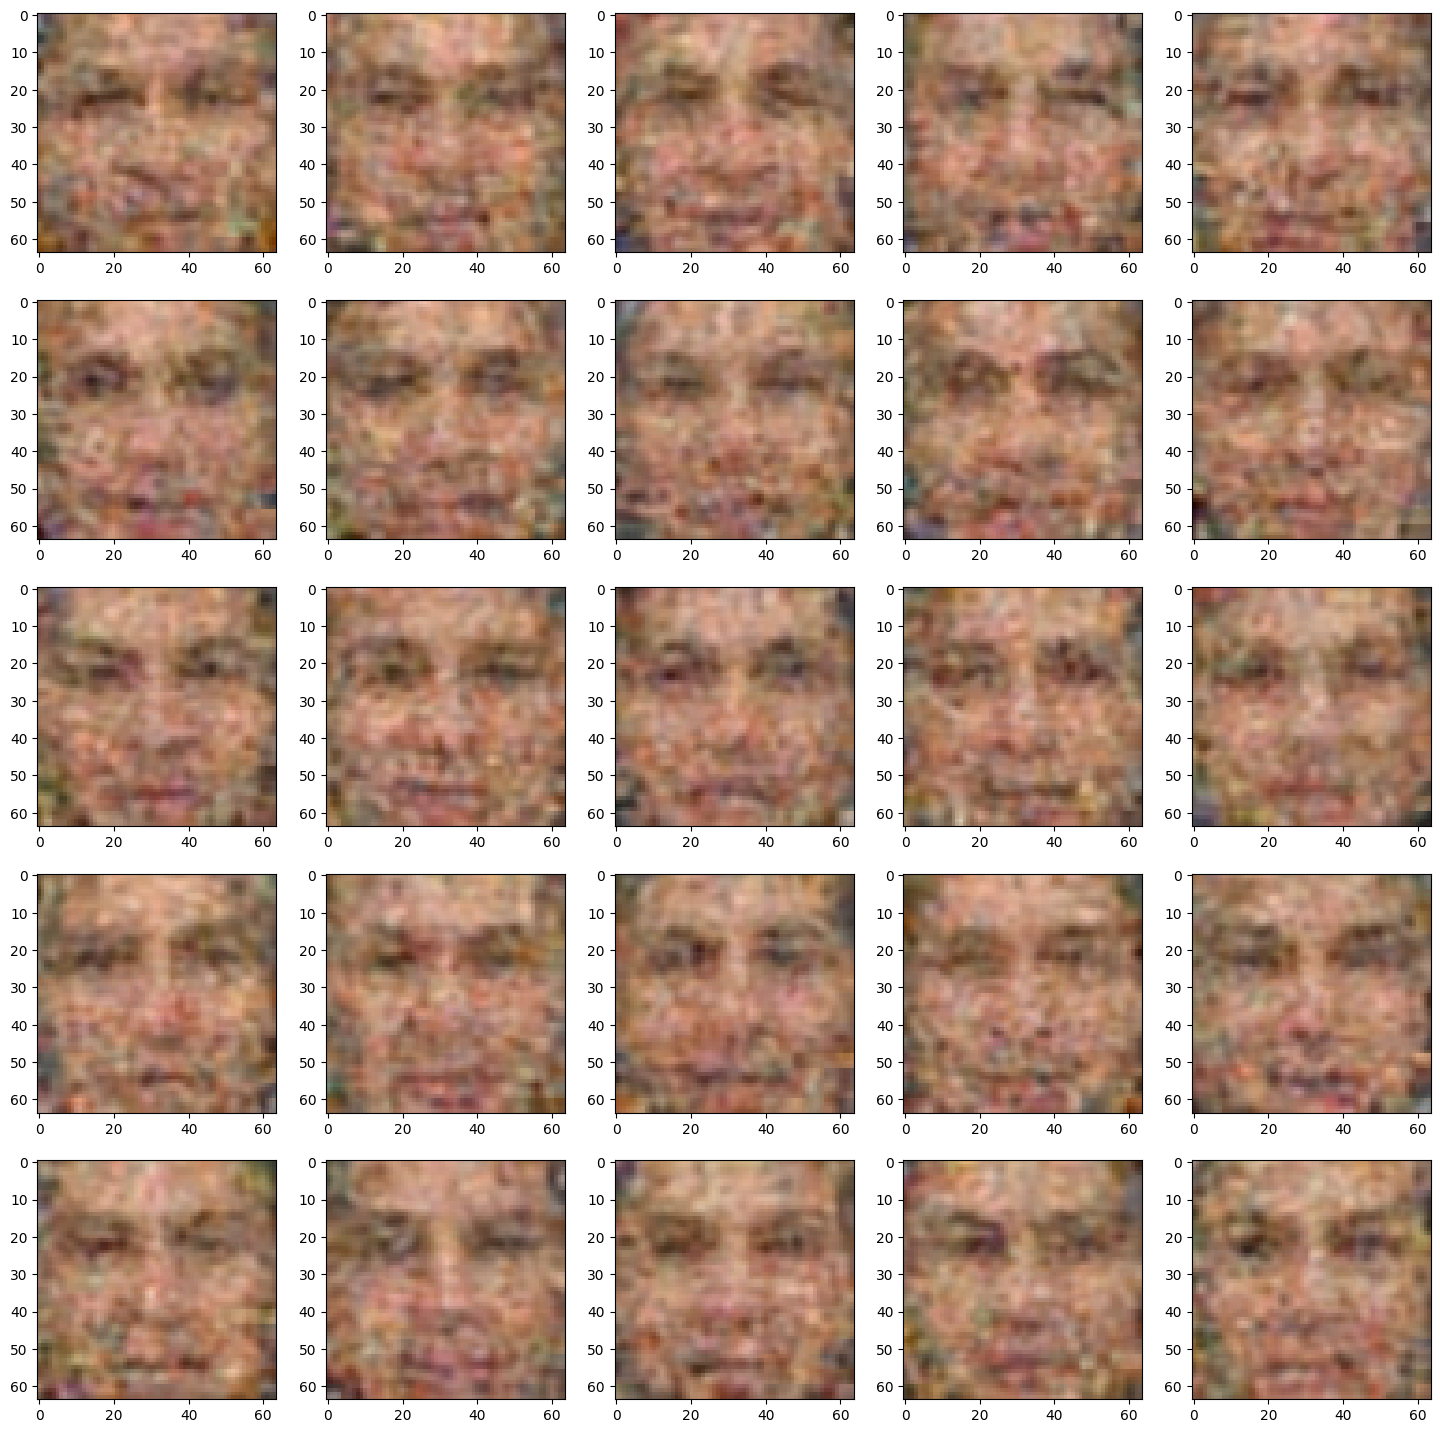

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
autoencoder.eval()
latent_vectors = []
#print(type(latent_vectors))

with torch.no_grad():
  for photo in X_train:
    photo = photo[None, :, :, :]
    #print(photo.shape)
    latent_code = autoencoder.encoder(photo.to(device))
    latent_vectors.append(latent_code)
    #print(type(latent_vectors))
latent_vectors = torch.cat(latent_vectors, dim=0)

#print(latent_vectors)
mean = torch.mean(latent_vectors, dim=0)
std = torch.std(latent_vectors, dim=0)
z_rand = np.array([np.random.normal(0, 1, (64, 10, 10)) for i in range(25)])
z_rand = torch.FloatTensor(z_rand)
z = mean + std * z_rand.to(device)

output = autoencoder.decoder(z)
#print(output.shape)
k = 0
fig, axs = plt.subplots(5, 5, figsize=(18, 18))
for i in range(5):
  for j in range(5):
    img = torch.permute(output[k].cpu().detach(), (1, 2, 0))
    axs[i, j].imshow(img)
    k += 1

plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smiling = attrs[attrs['Smiling'] > 1].index
frowning = attrs[attrs['Frowning'] > 1].index

smile = np.random.choice(smiling,15)
frown = np.random.choice(frowning,15)
X_smile = torch.permute(torch.tensor(data[smile], dtype=torch.float32), (0, 3, 1, 2))
X_frown = torch.permute(torch.tensor(data[frown], dtype=torch.float32), (0, 3, 1, 2))

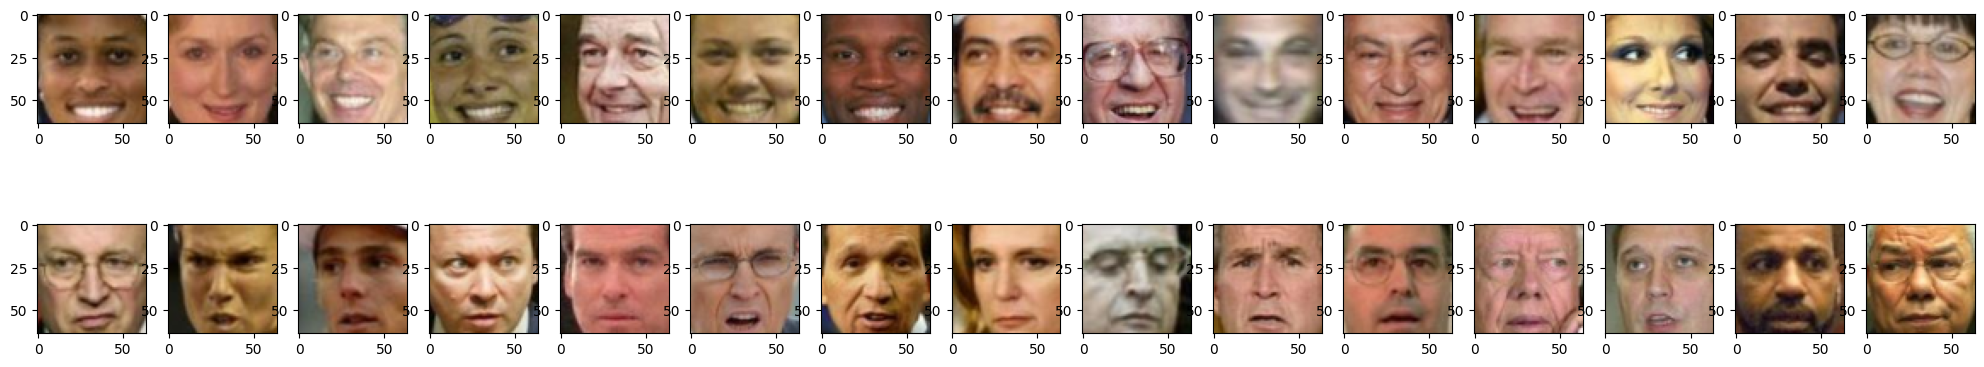

In [ ]:
fig, axs = plt.subplots(2, 15, figsize=(25, 5))
for i in range(15):
    axs[0, i].imshow(data[smile[i]])
for i in range(15):
    axs[1, i].imshow(data[frown[i]])

In [ ]:
autoencoder.eval()
latent_smile = []
latent_frown = []

with torch.no_grad():
  for photo in X_smile:
    photo = photo[None, :, :, :]
    latent_code = autoencoder.encoder(photo.to(device))
    latent_smile.append(latent_code)
  for photo in X_frown:
    photo = photo[None, :, :, :]
    latent_code = autoencoder.encoder(photo.to(device))
    latent_frown.append(latent_code)
latent_smile = torch.cat(latent_smile, dim=0)
latent_frown = torch.cat(latent_frown, dim=0)
mean_smile = torch.mean(latent_smile, dim=0)
mean_frown = torch.mean(latent_frown, dim=0)

In [ ]:
diff = mean_smile - mean_frown
toSmile = latent_frown + diff

In [ ]:
output = autoencoder.decoder(toSmile.to(device))

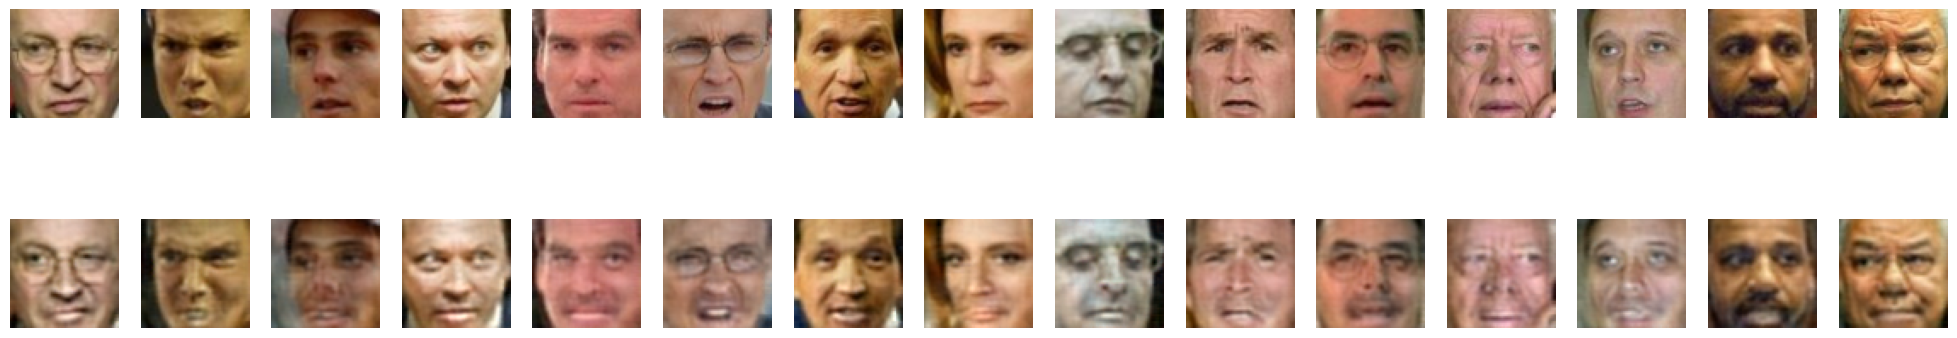

In [ ]:
fig, axs = plt.subplots(2, 15, figsize=(25, 5))
for i in range(15):
    img = torch.permute(output[i].cpu().detach(), (1, 2, 0))
    axs[1, i].imshow(img)
    axs[1, i].axis('off')
for i in range(15):
    img = torch.permute(X_frown[i].cpu().detach(), (1, 2, 0))
    axs[0, i].imshow(img)
    axs[0, i].axis('off')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 157777795.15it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33169686.15it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42530018.67it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20980758.56it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
dataloaders_mnist = {}
dataloaders_mnist['train'], dataloaders_mnist['val'] = train_loader, test_loader

In [ ]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encoder
        self.encoder1 = nn.Sequential (
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )
        self.encoder2 = nn.Sequential (
            nn.Linear(in_features=3*3*32, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(features, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, x):
        x = self.encoder1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.encoder2(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []
n_epochs = 100
for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch, _ in dataloaders_mnist['train']:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    if epoch % 5 == 0:
        print("Epoch: " + str(epoch) + "\nTrain loss: " + str(train_losses[-1]))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, _ in dataloaders_mnist['val']:
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    if epoch % 5 == 0:
        print(" Val loss: " + str(val_losses[-1]))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
Train loss: 35832.16836020789
 Val loss: 20954.153304860563
Epoch: 5
Train loss: 15141.455413362874
 Val loss: 14722.001277875297
Epoch: 10
Train loss: 13654.714335687633
 Val loss: 13450.518208564083
Epoch: 15
Train loss: 13138.635159165113
 Val loss: 13093.642468416238
Epoch: 20
Train loss: 12960.529852828491
 Val loss: 12804.903358942345
Epoch: 25
Train loss: 12858.155662813166
 Val loss: 12645.498519704312
Epoch: 30
Train loss: 12784.160458172308
 Val loss: 12677.022822512856
Epoch: 35
Train loss: 12726.006011377265
 Val loss: 12582.575932369957
Epoch: 40
Train loss: 12676.752490338486
 Val loss: 12524.733617855023
Epoch: 45
Train loss: 12642.608009061834
 Val loss: 12537.419047295292
Epoch: 50
Train loss: 12606.607313599414
 Val loss: 12496.172989084751
Epoch: 55
Train loss: 12586.252267540645
 Val loss: 12471.770113788074
Epoch: 60
Train loss: 12559.30069171442
 Val loss: 12469.94207995451
Epoch: 65
Train loss: 12533.019724896722
 Val loss: 12428.442854096618
Epoch: 70
T

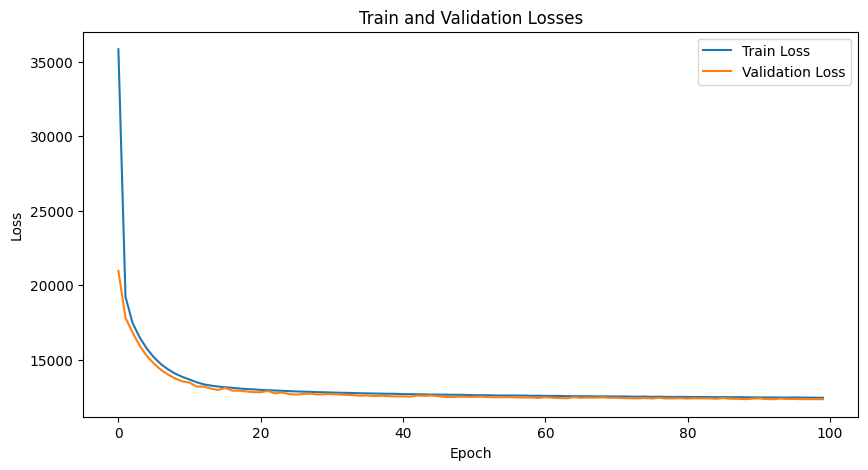

In [ ]:
# Визуализация графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for X_batch, _ in dataloaders_mnist['val']:
      mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      print(reconstruction.shape)
      reconstruction = np.rollaxis(reconstruction.detach().cpu().numpy(), 1, 4)
      ground_truth = np.rollaxis(X_batch.numpy(), 1, 4)
      break

torch.Size([128, 1, 28, 28])


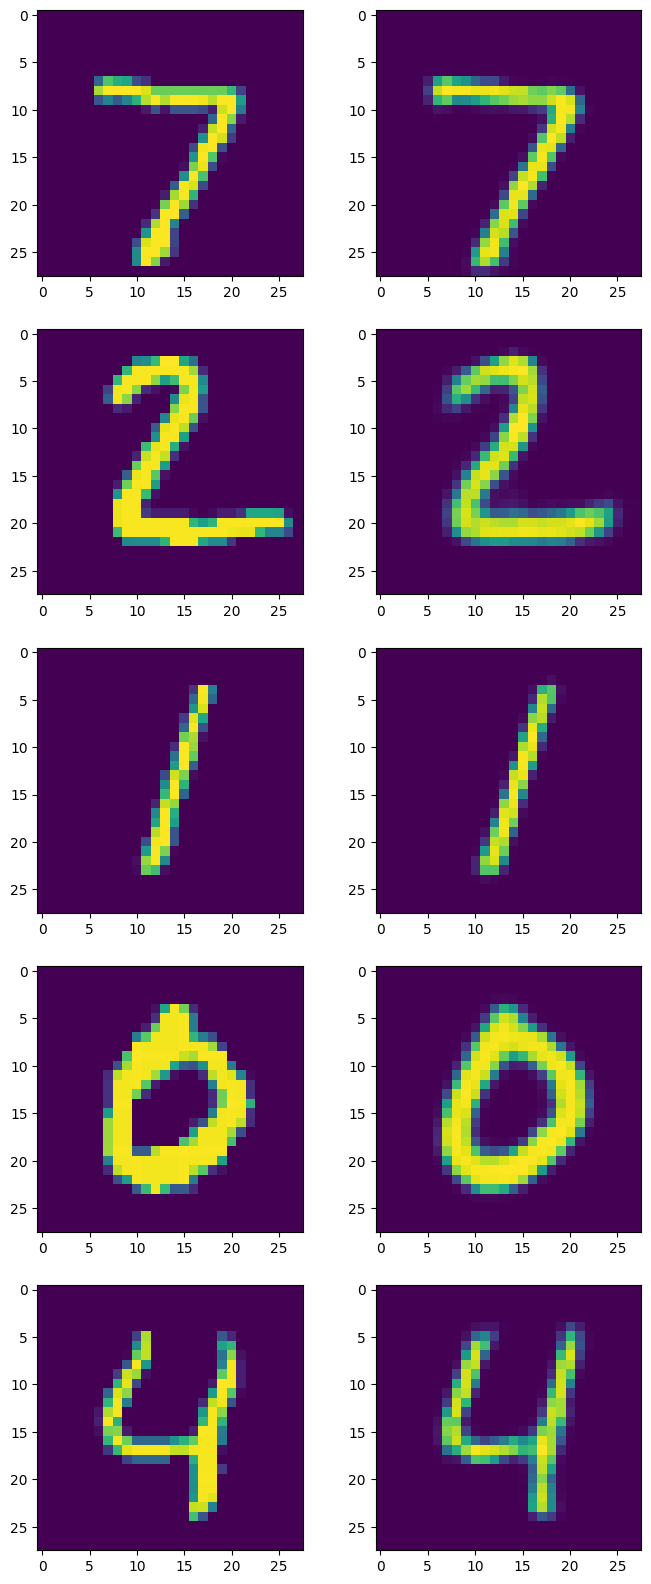

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[0:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt.squeeze())
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res.squeeze())

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
z = torch.FloatTensor(z)

In [ ]:
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, _ in dataloaders_mnist['val']:
        mean, log_var = autoencoder.encode(img.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)


total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)


z = torch.FloatTensor(z).to(device) * std + mean


output = autoencoder.decode(z)

output = output.view(-1, 1, 28, 28)
output = np.rollaxis(output.detach().cpu().numpy(), 1, 4)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
def get_latent_vector(x):
    x = autoencoder.encoder1(x)
    x = torch.flatten(x, start_dim=1)
    x = autoencoder.encoder2(x).view(-1, 2, features)
    mu = x[:, 0, :]
    logsigma = x[:, 1, :]
    std = torch.exp(0.5 * logsigma)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    return sample

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

encoded_samples = []
for img, label in test_dataset:
    autoencoder.eval()
    with torch.no_grad():
        img = img[None, :, :, :]
        encoded_img  = get_latent_vector(img.to(device))

    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}

    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

## 2.3. Conditional VAE (6 баллов)


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features + 10, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )

    def encode(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def decode(self, z, class_num):
        z_concated = torch.cat([z, class_num], 1)
        x = self.decoder(z_concated)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        x = self.flatten(x).float()
        mu, logsigma, class_num = self.encode(x, class_num)


        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return reconstruction, mu, logsigma,

    def get_latent_vector(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        z = self.gaussian_sampler(mu, log_var)
        return z

In [ ]:
cond_autoencoder = CVAE().to(device)

In [ ]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [ ]:
criterion = loss_vae
cond_dim = train_loader.dataset.train_labels.unique().size(0)
optimizer = torch.optim.Adam(cond_autoencoder.parameters(), lr=0.001, weight_decay=1e-04)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning:

train_labels has been renamed targets



In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    cond_autoencoder.train()
    train_losses_per_epoch = []
    for batch, cond in dataloaders_mnist['train']:
        cond = one_hot(cond, cond_dim)
        optimizer.zero_grad()
        reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    if epoch % 5 == 0:
        print("Epoch: " + str(epoch) + "\nTrain loss: " + str(train_losses[-1]))

    cond_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, cond in dataloaders_mnist['val']:
            cond = one_hot(cond, cond_dim)
            reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    if epoch % 5 == 0:
        print(" Val loss: " + str(val_losses[-1]))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train loss: 20758.539035431102
 Val loss: 15752.079078384593
Epoch: 5
Train loss: 13559.706312883129
 Val loss: 13256.99230493473
Epoch: 10
Train loss: 13050.912985990804
 Val loss: 12838.901115320907
Epoch: 15
Train loss: 12829.795113439499
 Val loss: 12665.842003930973
Epoch: 20
Train loss: 12699.905263026387
 Val loss: 12528.81756823576
Epoch: 25
Train loss: 12603.37837320096
 Val loss: 12469.901768937896
Epoch: 30
Train loss: 12528.371324876733
 Val loss: 12442.029505476166
Epoch: 35
Train loss: 12473.000143673375
 Val loss: 12399.171377447587
Epoch: 40
Train loss: 12430.782599280385
 Val loss: 12330.668143356903
Epoch: 45
Train loss: 12387.214087903118
 Val loss: 12352.500015451938


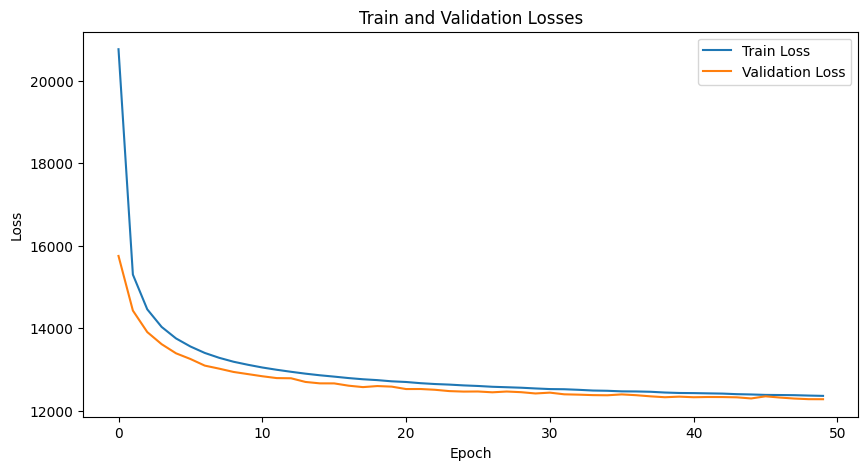

In [ ]:
# Визуализация графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(1)])
z = torch.FloatTensor(z)

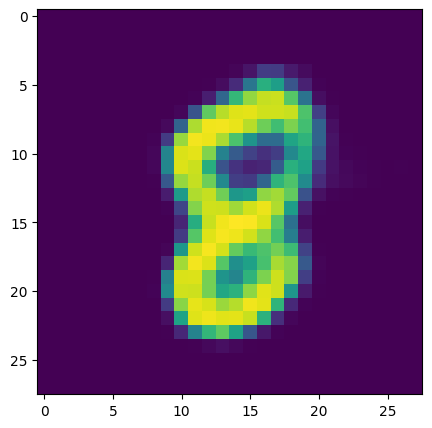

In [ ]:
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, cond in test_loader:
        cond = one_hot(cond, cond_dim)
        mean, log_var, label = cond_autoencoder.encode(img.to(device), cond.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)


total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)

z = z.to(device) * std + mean


output = cond_autoencoder.decode(z, one_hot(torch.LongTensor([8]), cond_dim).to(device)) # output = <скормите z декодеру>
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

plt.figure(figsize=(18, 5))

generated = output_new.cpu().detach().numpy()
plt.imshow(np.squeeze(generated))

plt.show()

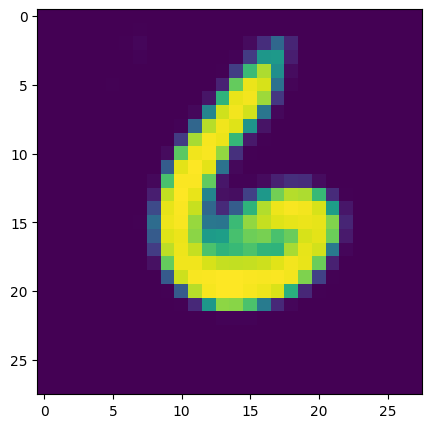

In [ ]:

output = cond_autoencoder.decode(z, one_hot(torch.LongTensor([6]), cond_dim).to(device)) # output = <скормите z декодеру>
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

plt.figure(figsize=(18, 5))

generated = output_new.cpu().detach().numpy()
plt.imshow(np.squeeze(generated))

plt.show()

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
encoded_samples = []
for img, label in test_dataset:


    cond_autoencoder.eval()
    with torch.no_grad():
        encoded_img  = cond_autoencoder.get_latent_vector(img.to(device),
                                                     one_hot(torch.LongTensor([label]), cond_dim).to(device))

    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}

    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()